In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler


from neural_network import NeuralNetwork
from methods import *
from data_gen import Poly1D2Deg, FrankeDataGen, CancerData
from iristest import test_iris

np.random.seed(4155) # FYS-STK4155 

/Users/miamerlid/anaconda3/envs/fysstk/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#test_iris()

In [3]:
data = FrankeDataGen()

In [4]:
inputs = jnp.column_stack((data.x.flatten(), data.y.flatten()))  
targets = data.z.ravel().reshape(-1, 1)                          

In [5]:
input_size = 2
output_size = 1
hidden_layers = [32, 16, 8]
network_shape = [input_size] + hidden_layers + [output_size]
activation_funcs = ["ReLU", "sigmoid", "ReLU", "identity"]
cost_fun = mse

model = NeuralNetwork(network_shape, activation_funcs, cost_fun)

In [6]:
_, accuracy_list, loss_list, preds = model.train_network(inputs, targets, epochs=10000, learning_rate=0.01)

100%|██████████| 2000/2000 [00:40<00:00, 49.65it/s]


In [ ]:
print("Final accuracy: ", accuracy_list[-1])

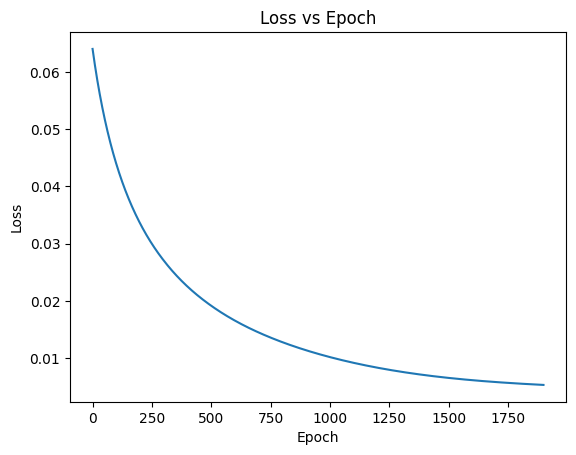

In [7]:
plt.plot(loss_list[100:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.show()

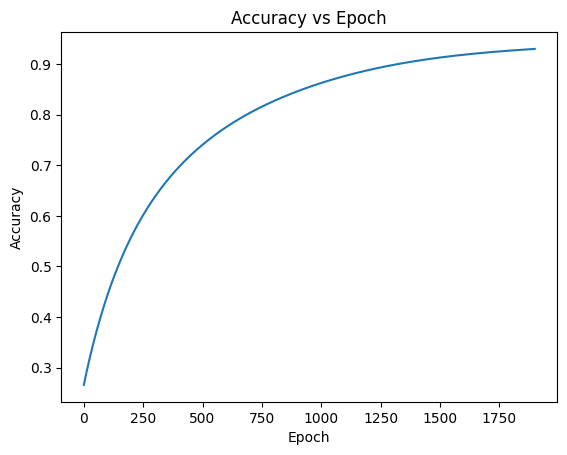

In [8]:
plt.plot(accuracy_list[100:])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epoch")
plt.show()

In [10]:
print("Final accuracy: ", accuracy_list[-1])

Final accuracy:  0.9296699770585043
